# How to actually pre-process Datasets?

In [3]:
!pip install -q --upgrade pip

In [129]:
!pip install -q scipy scikit-learn polars

In [145]:
import os
from collections import Counter

from scipy.io import arff
import pandas as pd
import polars as pl
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer

In [7]:
DATASET_LIST = !cat ../datasets/datasets.txt
ARFF_PATH = '../datasets/arff/'

In [ ]:
data

## ARFF datasets

In [8]:
arff_files = {dataset: os.path.join(ARFF_PATH, dataset + ".arff") for dataset in DATASET_LIST}

### Exemplo Teste

Analisando o dataset `ozone-eighthr`, que apresentou resultados praticamente aletórios no meu experimento

In [113]:
chosen_dataset = "ozone-eighthr"

In [114]:
data, metadata = arff.loadarff(arff_files[chosen_dataset])
data_df = pd.DataFrame(data)

O dataset possui apenas valores numéricos, o que torna desnecessária a codificação de atributos nominais.
Dessa forma se ele apresentar um desempenho ruim, há um indicativo de que o problema não está na codificação, mas em outra parte do pre-processamento.

In [115]:
pd.value_counts(metadata.types())

numeric    72
nominal     1
Name: count, dtype: int64

Testando desempenho do SVM padrão do sklearn no dataset escolhido

In [116]:
X, y = data_df.iloc[:, :-1], LabelEncoder().fit_transform(data_df.iloc[:, -1])
X.shape, y.shape

((2534, 72), (2534,))

In [117]:
Counter(y)

Counter({0: 2374, 1: 160})

In [118]:
clf = SVC()
scaler = StandardScaler()
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [119]:
X = scaler.fit_transform(X)

In [121]:
def test_passive(clf, X, y):
    score_list = []

    for _ in range(5):
        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            clf.fit(X_train, y_train)
    
            y_pred = clf.predict(X_test)
    
            kappa = cohen_kappa_score(y_pred, y_test)
            f1 = f1_score(y_test, y_pred)
            score_list.append(kappa)
        
    score_list = np.array(score_list)
    return score_list

O pré-processamento dos dados levou a um desempenho melhor, mesmo que muito pequeno:

In [122]:
score_list = test_passive(clf, X, y)
print(f'{score_list.mean()} +/- {score_list.std()}')

0.027032453561427746 +/- 0.032238402080198104


### Comparando com resultados do Davi

In [18]:
# !tar -xzf results_davi.tgz

In [97]:
from io import StringIO

def get_results_davi(dataset):
    
    search_string = f"'{dataset}.*SVM'"

    lines = !grep -E $search_string neurocomputing2019-kappa-5x5-fold-75datasets-15strats-5classifs.csv
    
    result = pd.read_csv(StringIO( '\n'.join(lines)), names=["dataset", "method", "learner", "fold", "run", "query", "kappa"])

    return result
   

In [95]:
df = get_results_davi(chosen_dataset)
df.head()

,dataset,method,learner,fold,run,query,kappa
0,ozone-eighthr,SG,SVM,0,0,0,-0.031033
1,ozone-eighthr,SG,SVM,0,0,1,-0.067304
2,ozone-eighthr,SG,SVM,0,0,2,0.000000
3,ozone-eighthr,SG,SVM,0,0,3,0.000000
4,ozone-eighthr,SG,SVM,0,0,4,0.000000


In [98]:
print(list(df.method.unique()))

[' SG', ' OER', ' HTUmah', ' HTUeuc', ' Mar', ' TUeuc', ' Rnd', ' TUmah', ' ATUmah', ' TUman', ' HTUman', ' ERE', ' ATUman', ' HS', ' ATUeuc']


In [199]:
def plot_curve(df, method):
    fig, ax = plt.subplots()

    ax.set_title("Active Learning (Santos 2019)")
    ax.set_ylim(-1, 1)
    ax.grid(True)
    for group, data in df.groupby(["method", 'fold', 'run']):
        if group[0] == method:
            ax.plot(data['kappa'].values, linestyle=":", color='steelblue', alpha=0.5)
           

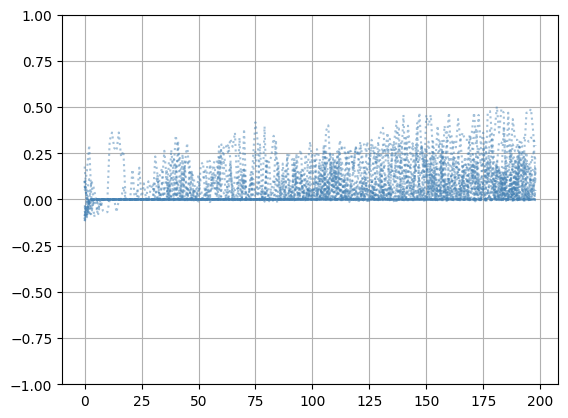

In [99]:
plot_curve(df, ' Rnd')

### Conclusões

Visto que o dataset é muito desbalanceado, existe a possibilidade de o uso do conjunto de dados completo tenha um desempenho pior do que o active learning em si. O que explicaria o desempenho ruim do aprendizado passivo.
Entretanto, **está hipótese ainda precisa ser testada** por meio da aplicação de active learning nas minhas configurações e com o pré-processamento dos dados.

Além disso, é necessário reproduzir em exeperimento em um conjunto de dados, onde o desempenho final do AL seja mais próximo do desempnho do aprendizado passivo

## Segundo Exemplo de Teste

In [128]:
data, metadata = arff.loadarff(arff_files['horse-colic-surgical'])

### Resultados do Davi

In [105]:
results_davi = get_results_davi('horse-colic-surgical')
results_davi.head()

,dataset,method,learner,fold,run,query,kappa
0,horse-colic-surgical,SG,SVM,0,0,0,-0.139601
1,horse-colic-surgical,SG,SVM,0,0,1,-0.339869
2,horse-colic-surgical,SG,SVM,0,0,2,-0.290323
3,horse-colic-surgical,SG,SVM,0,0,3,-0.352201
4,horse-colic-surgical,SG,SVM,0,0,4,0.078947


Com base no plot abaixo, é esperado que o SVM seja capaz de atigir um kappa próximo de 0.75 usando todos os dados

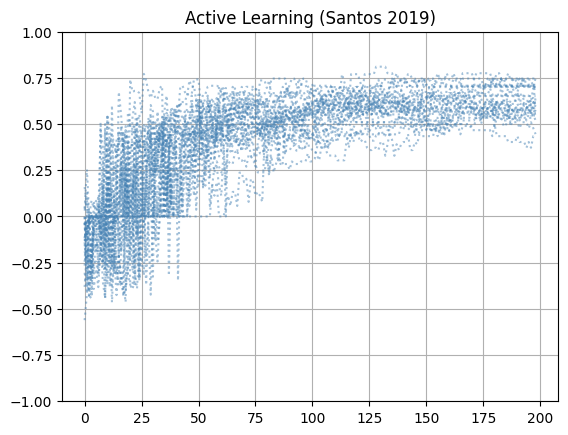

In [200]:
plot_curve(results_davi, ' Rnd')

### Testando Aprendizado Passivo

In [132]:
data_df = pd.DataFrame(data)
data_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,Class
0,b'2',1.0,530101.0,38.5,66.0,28.0,b'3',b'3',b'1',b'2',...,45.0,8.4,b'2',3.019608,b'2',11300.0,0.0,0.0,2.0,b'2'
1,b'1',1.0,534817.0,39.2,88.0,20.0,b'3',b'1',b'4',b'1',...,50.0,85.0,b'2',2.000000,b'3',2208.0,0.0,0.0,2.0,b'2'
2,b'2',1.0,530334.0,38.3,40.0,24.0,b'1',b'1',b'3',b'1',...,33.0,6.7,b'2',3.019608,b'1',0.0,0.0,0.0,1.0,b'2'
3,b'1',9.0,5290409.0,39.1,164.0,84.0,b'4',b'1',b'6',b'2',...,48.0,7.2,b'3',5.300000,b'2',2208.0,0.0,0.0,1.0,b'1'
4,b'2',1.0,530255.0,37.3,104.0,35.0,b'3',b'1',b'6',b'2',...,74.0,7.4,b'2',3.019608,b'2',4300.0,0.0,0.0,2.0,b'2'


In [133]:
X, y = data_df.iloc[:, :-1], data_df.iloc[:, -1]
X.shape, y.shape

((300, 27), (300,))

Preprocessamento:

In [287]:
nominal_mask = [x == 'nominal' for x in metadata.types()][:-1]
numeric_mask = [not x for x in nominal_mask]

one_hot_encoder = OneHotEncoder(sparse_output=False)
standard_scaler = StandardScaler()

column_transformers = [
    ('one-hot-encoder' , one_hot_encoder, nominal_mask),
    ('standard-scaler', standard_scaler, numeric_mask)
]
preprocessor = ColumnTransformer(column_transformers, remainder='passthrough')

In [288]:
X_new = preprocessor.fit_transform(X)
y_new = LabelEncoder().fit_transform(y)
X_new.shape, y_new.shape

((300, 66), (300,))

In [289]:
score_list = test_passive(SVC(), X_new, y_new)
print(f'{score_list.mean()} +/- {score_list.std()}')

0.6543287559745294 +/- 0.07123225638599807


### Testando AL dos experimentos

In [213]:
# X_new['Class'] = y_new
# X_new.to_csv('../experiments/horse-colic-surgical.csv')

In [221]:
rand_df = pd.read_csv('random_sampling_5_horse-colic-surgical.csv', index_col=0)
margin_df = pd.read_csv('margin_sampling_5_horse-colic-surgical.csv', index_col=0)

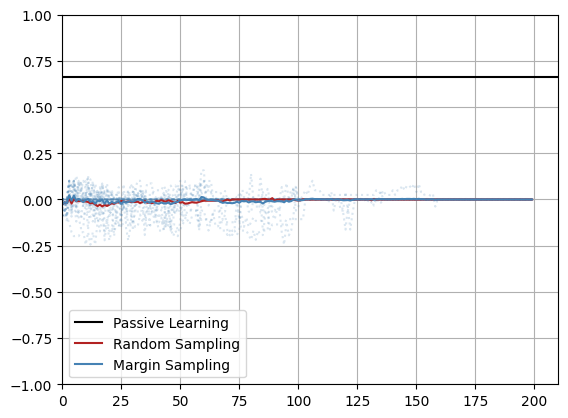

In [246]:
fig, ax = plt.subplots()

for k, c in margin_df.items():
    ax.plot(c, color="steelblue", linestyle=":", alpha=0.2)

ax.axhline(score_list.mean(), color="black", label="Passive Learning")
ax.plot(rand_df.mean(axis=1), color="firebrick", label="Random Sampling")
ax.plot(margin_df.mean(axis=1), color="steelblue", label="Margin Sampling")

ax.set_ylim(-1,1)
ax.set_xlim(0,210)
ax.grid(True)
ax.legend()

### Testando Aprendizado Ativo do zero

In [249]:
!pip install -q modAL-python

In [297]:
from modAL.models import ActiveLearner
from sklearn.model_selection import train_test_split
from modAL.uncertainty import margin_sampling

In [349]:
def test_active_learning(X_train, y_train, X_test, y_test, budget=200, query_strategy=margin_sampling):
    
    # seleciona dados iniciais para serem rotulados 
    l_index = np.zeros(len(y_train),dtype=bool)
    initial_label_mask = np.random.choice(np.arange(len(y_train)), size=5)
    l_index[initial_label_mask] = True

    # Cria Pool L
    X_l_pool, y_l_pool = X_train[l_index], y_train[l_index]
    
    # Cria Pool U
    X_u_pool, y_u_pool = X_train[~l_index], y_train[~l_index]

    # Instancia aprendiz ativo
    learner = ActiveLearner(estimator=SVC(probability=True),
                            X_training=X_l_pool,
                            y_training=y_l_pool,
                            query_strategy=query_strategy)

    score_list = []
    
    for x in range(budget):
    
        query_index, _ = learner.query(X_u_pool)

        learner.teach(X_u_pool[query_index], y_u_pool[query_index])

        X_u_pool = np.delete(X_u_pool, query_index, axis=0)
        y_u_pool = np.delete(y_u_pool, query_index)
    
        y_pred = learner.predict(X_test)

        score = cohen_kappa_score(y_pred, y_test)

        score_list.append(score)

    return score_list

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(240, 66) (240,)
(60, 66) (60,)


In [347]:
pd.value_counts(y_test)

0    38
1    22
Name: count, dtype: int64

In [352]:
margin_score = test_active_learning(X_train, y_train, X_test, y_test)

In [ ]:
def random_sampling(learner, X, n_instances=1):

    query_idx = np.random.choice(range(len(X)), size=n_instances,
                                 replace=False)

    return query_idx, X[query_idx]
    
random_score = test_active_learning(X_train, y_train, X_test, y_test)

array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0])